# Experiment on passing i.i.d. data to pyro.condition


(Building the same model as pyro documentation: http://pyro.ai/examples/intro_part_ii.html#Conditioning-Models-on-Data)

In [6]:
# import some dependencies
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="ticks")

import torch
import torch.distributions.constraints as constraints

import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC
from pyro.infer.mcmc.nuts import NUTS
torch.manual_seed(101);

## Model

In [2]:
def scale(guess):
    # The prior over weight encodes our uncertainty about our guess
    # This is one dimension
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    # This encodes our belief about the noisiness of the scale:
    # the measurement fluctuates around the true weight
    # data point here is also one dimensional
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

## Conditioning Models on Data

tensor(12.5057)


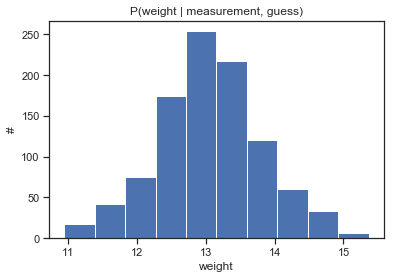

In [3]:
guess = 1.0
measurement = 20.

conditioned_scale = pyro.condition(scale, data={"measurement": measurement})

#marginal = pyro.infer.EmpiricalMarginal(
#    pyro.infer.Importance(conditioned_scale, num_samples=1000).run(guess), sites="weight")
nuts_kernel = NUTS(conditioned_scale, adapt_step_size=True)
mcmc_run = MCMC(nuts_kernel, num_samples=500, warmup_steps=300).run(guess)
marginal = pyro.infer.EmpiricalMarginal(mcmc_run, 'weight')

# The marginal distribution concentrates around the data
print(marginal())
plt.hist([marginal().item() for _ in range(1000)],)
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#");

## Conditioning Model with i.i.d. Data

In [5]:
# Number of i.i.d. samples

# sample i.i.d points
measurement = torch.tensor([21.0, 20.0, 19.0, 19.5, 20.5])

# condition
with pyro.iarange("data", len(measurement)) as ind:
    x=ind
    measurement_batch = measurement[[ind]]
    conditioned_scale_iid = pyro.condition(scale, data={"measurement": measurement_batch})

num_samples = 1000
#marginal = pyro.infer.EmpiricalMarginal(
#    pyro.infer.Importance(conditioned_scale, num_samples=1000).run(1.0), sites="weight")
nuts_kernel = NUTS(conditioned_scale_iid, adapt_step_size=True)
mcmc_run = MCMC(nuts_kernel, num_samples=500, warmup_steps=300).run(1.0)
marginal = pyro.infer.EmpiricalMarginal(mcmc_run, 'weight')

tensor(17.7418)


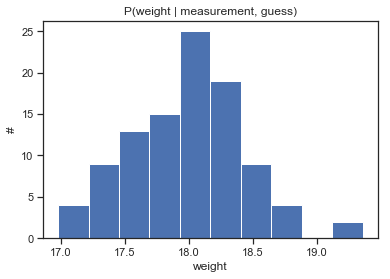

In [6]:
print(marginal())
plt.hist([marginal().item() for _ in range(100)])
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#");

In [ ]:
# One dimensional data point, n dimensional data
z1 = torch.tensor(0.)
s1 = torch.tensor(10.)
n = torch.Size([10])
# Without use of 'independent'
x1 = dist.Normal(z1, s1).sample(sample_shape = n)
# With use of 'independent'
x2 = dist.Normal(z1, s1).independent().sample(sample_shape = n)

# K-dimensional data point, n dimensional data
z2 = torch.tensor([0., 100.])
s2 = torch.tensor([[1., 10.], [10., 1.]])
# Without use of 'independent'
x3 = dist.Normal(z2, s2).sample(sample_shape = n)
# With use of 'independent'
x4 = dist.Normal(z2, s2).independent().sample(sample_shape = n)


# Variational Inference

In [72]:
def prev_scale(guess):
    # The prior over weight encodes our uncertainty about our guess
    # This is one dimension
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    # This encodes our belief about the noisiness of the scale:
    # the measurement fluctuates around the true weight
    # data point here is also one dimensional
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

def scale(data):
    guess = torch.tensor(8.)
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    f = pyro.sample("measurement", dist.Normal(weight, 0.75))
    
    # Normal
    #for i in range(len(data)):
    #    pyro.sample("obs_{}".format(i), dist.Normal(f, 0.75), obs=data[i])
        
    # Conditionally independent
    with pyro.iarange('observe_data'):
        pyro.sample('obs', dist.Normal(f,0.75), obs=data)


def scale_guide(data):
    guess_q = pyro.param("guess_q", torch.tensor(8.), 
                          constraint=constraints.positive)
    weight = pyro.sample("weight", dist.Normal(guess_q, 1.0))
    
    pyro.sample("measurement", dist.Normal(guess_q, 0.75))

In [73]:
# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(scale, scale_guide, optimizer, loss=Trace_ELBO())

In [74]:
# this is for running the notebook in our testing framework
n_steps = 2000

# create data
measurement = torch.tensor([18.,19.,13.,17.5,16.,18.2,20.5])
#measurement = torch.tensor([8.,9.,3.,7.5,6.,8.2,10.5])

# do gradient steps
for step in range(n_steps):
    svi.step(measurement)
    if step % 100 == 0:
        print('.', end='')

....................

In [75]:
guess_q = pyro.param("guess_q").item()
guess_q

16.720230102539062